In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import performance_metrics
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras import Sequential, layers
from keras.layers import Dense, Dropout
from pickle import load

In [2]:
# raw_data = pd.read_csv(r"../data/processed_data/undersampled_train.csv", index_col=0)
data = pd.read_csv(r"../data/processed_data/complete_data.csv", index_col=0)

In [15]:
# split into features
x = data.drop(["TARGET"], axis=1)
y = data.filter(["TARGET"], axis=1)
y = y.values.reshape(y.shape[0])

# split dataset for hyperparameter tuning and kfold
split = 0.5
hp_x, hp_y = x[:int(len(x) * split)], y[:int(len(y) * split)] # hyperparameter set
kf_x, kf_y = np.array(x[int(len(x) * split):]), y[int(len(y) * split):] # kfold set

hp_x.shape, hp_y.shape, kf_x.shape, kf_y.shape


((282686, 202), (282686,), (282686, 202), (282686,))

In [6]:
# scale the data for hyperparameter tuning
scaler = StandardScaler()
hp_x = scaler.fit_transform(hp_x)

In [6]:
def model_builder(hp):
    model = Sequential()

    # input layer
    model.add(Dense(units=x.shape[1], input_shape=(x.shape[1],)))

    # let the model decide how many layers it wants to have
    for i in range(hp.Int("num_dense_layers", min_value=2, max_value=5, step=1)):
        model.add(
            Dropout(hp.Float("dropout_" + str(i), min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            Dense(
                units=hp.Int("layer_" + str(i), min_value=32, max_value=1024, step=64),
                activation=hp.Choice("act_" + str(i), ["relu", "sigmoid"]),
            )
        )

    # output shape of the model the same as the number of features
    model.add(
        Dense((1), activation="sigmoid"),
    )

    # compile the model
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(), "accuracy"],
    )

    return model

In [13]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=2)

In [7]:
project = "nn_v1"

tuner = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective("accuracy", direction="max"),
    max_trials=20,  # I could stop it earlier, or even let it run forever but, my computer isn't powerful enough
    directory=f"../logs/nn/{project}",
    project_name=project,
)

INFO:tensorflow:Reloading Tuner from ../logs/nn/nn_v1\nn_v1\tuner0.json


In [ ]:
tuner.search(
    hp_x,
    hp_y,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[earlyStop],
)

Trial 18 Complete [00h 03m 26s]
accuracy: 0.5008578300476074

Best accuracy So Far: 0.9640102982521057
Total elapsed time: 00h 36m 10s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_dense_layers
0.4               |0.1               |dropout_0
288               |352               |layer_0
sigmoid           |sigmoid           |act_0
0.3               |0.4               |dropout_1
288               |160               |layer_1
sigmoid           |sigmoid           |act_1
0.001             |0.001             |learning_rate
0.3               |0.4               |dropout_2
480               |672               |layer_2
relu              |sigmoid           |act_2
0                 |0.1               |dropout_3
800               |608               |layer_3
sigmoid           |relu              |act_3
0.2               |0.2               |dropout_4
288               |672               |layer_4
sigmoid           |sigmoid     

In [20]:
hpModel = tuner.get_best_models()[0]
hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

hpModel.summary() #, hyperparameters.values

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 202)               41006     
                                                                 
 dropout (Dropout)           (None, 202)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               32480     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 288)               46368     
                                                                 
 dropout_2 (Dropout)         (None, 288)               0         
                                                                 
 dense_3 (Dense)             (None, 352)               1

In [21]:
# save the model architecture for another time
hpModel.save(f"neural_network/{project}")

INFO:tensorflow:Assets written to: neural_network/BayOpt_v3\assets


In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=663)

results = pd.DataFrame(
    columns=["accuracy", "precision", "recall", "f1", "auc", "fpr", "fnr"]
)
results.index.name = "Model"

model = keras.models.load_model(f"neural_network/{project}/")

counter = 1
confusion_matrix_sum = None

for train_index, test_index in kfold.split(kf_x):
    x_train, x_test = kf_x[train_index], kf_x[test_index]
    y_train, y_test = kf_y[train_index], kf_y[test_index]
    
    # scale x features
    scaler = StandardScaler()
    x_train, x_test = scaler.fit_transform(x_train), scaler.transform(x_test)

    # fit model to train set
    trained_model = model.fit(x_train, y_train, epochs=10, batch_size=64, callbacks=earlyStop)
    y_pred = model.predict(x_test)

    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

    # calculate confusion matrix, and append data for later visualisation
    cm = confusion_matrix(y_test, y_pred_binary)
    fpr = cm[0][1] / cm.sum()
    fnr = cm[1][0] / cm.sum()

    if confusion_matrix_sum is None:
        confusion_matrix_sum = cm
    else:
        confusion_matrix_sum += cm

    # calculate metrics and append to dataframe
    metrics = performance_metrics.metrics(y_test, y_pred_binary)
    accuracy, precision, recall, f1, auc_result = metrics.calculate_metrics()
    results.loc[counter] = [accuracy, precision, recall, f1, auc_result, fpr, fnr]

    print(f"Fold {counter} completed")
    counter += 1

# calculate the average over all models
results.loc["Average"] = [
    results.accuracy.mean(),
    results.precision.mean(),
    results.recall.mean(),
    results.f1.mean(),
    results.auc.mean(),
    results.fpr.mean(),
    results.fnr.mean(),
]

Epoch 1/10
3534/3534 [==============================] - 24s 7ms/step - loss: 0.0947 - auc: 0.9915 - accuracy: 0.9658
Epoch 2/10
3534/3534 [==============================] - 22s 6ms/step - loss: 0.0921 - auc: 0.9920 - accuracy: 0.9668
Epoch 3/10
3534/3534 [==============================] - 22s 6ms/step - loss: 0.0904 - auc: 0.9923 - accuracy: 0.9675
Epoch 4/10
3534/3534 [==============================] - 22s 6ms/step - loss: 0.0897 - auc: 0.9925 - accuracy: 0.9678
Epoch 5/10
3534/3534 [==============================] - 22s 6ms/step - loss: 0.0887 - auc: 0.9927 - accuracy: 0.9680
Epoch 6/10
3534/3534 [==============================] - 23s 7ms/step - loss: 0.0877 - auc: 0.9928 - accuracy: 0.9685
Epoch 7/10
3534/3534 [==============================] - 23s 6ms/step - loss: 0.0872 - auc: 0.9929 - accuracy: 0.9684
Epoch 8/10
3534/3534 [==============================] - 23s 7ms/step - loss: 0.0861 - auc: 0.9931 - accuracy: 0.9690
Epoch 9/10
3534/3534 [==============================] - 24s 7ms/

In [19]:
# save to csv for easy viewing
results.to_csv(f"../results/neural_network/scores-{project}.csv")

results.round(4) * 100

,accuracy,precision,recall,f1,auc,fpr,fnr
Model,,,,,,,
1,96.88,98.89,94.83,96.82,96.88,0.53,2.59
2,97.03,98.46,95.61,97.02,97.04,0.76,2.22
3,97.10,98.18,95.95,97.05,97.09,0.89,2.01
4,97.09,98.99,95.17,97.05,97.10,0.49,2.43
5,97.20,98.73,95.60,97.14,97.19,0.61,2.19
Average,97.06,98.65,95.43,97.01,97.06,0.65,2.29


In [20]:
# save confusion matrix
cm_df = pd.DataFrame(confusion_matrix_sum)
cm_df.to_csv(f"../results/neural_network/cmdata-{project}.csv")

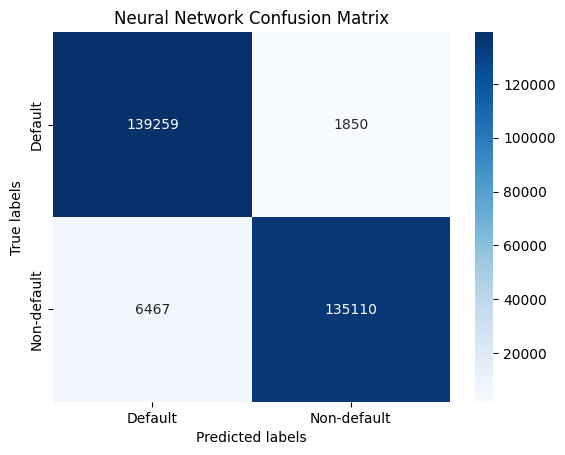

<Figure size 640x480 with 0 Axes>

In [21]:
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix_sum, annot=True, cmap="Blues", fmt="d")

# Set labels, title, and axis ticks
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Neural Network Confusion Matrix")

tick_labels = ["Default", "Non-default"]
tick_positions = [0, 1]
plt.xticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)
plt.yticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)

# Show the plot
plt.show()

plt.tight_layout()
fig.savefig(f"../results/neural_network/cm-{project}.png")

In [22]:
# interpretation_model = hpModel.fit(kf_x, kf_y, epochs=10, batch_size=64, callbacks=earlyStop)
# hpModel.save(f"neural_network/interpretation_model-{projcet}")